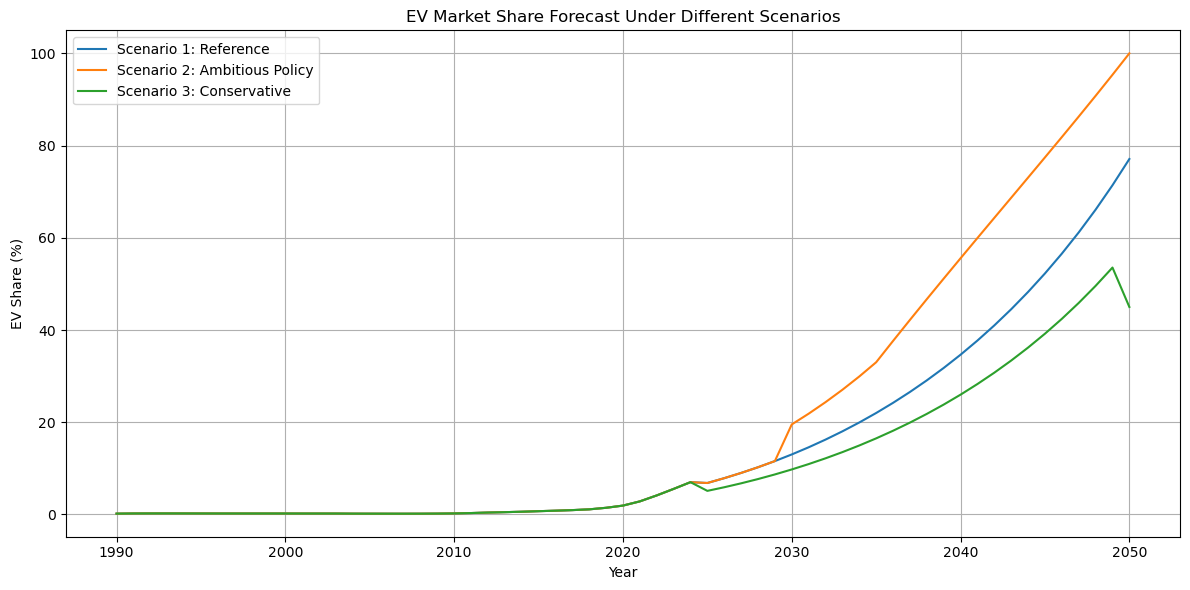

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os


# Parameters for tweaking
EV_GROWTH_FACTOR_SCENARIO_2 = 1.5        # Accelerated EV growth after 2030
POLICY_CUTOFF_YEAR = 2035               # No ICE sales after this year
FULL_EV_YEAR = 2050                     # Target year for full electrification
EV_SHARE_TARGET_SCENARIO_3 = 0.45       # Conservative scenario EV share target
EV_SHARE_REDUCTION_FACTOR = 0.75        # Slowdown factor for conservative scenario after 2025
ECO_REDUCTION_START_YEAR = 2030         # Start year for reducing total vehicle count
ECO_REDUCTION_MIN_FACTOR = 0.8          # Minimum reduction limit (20% below 2030 level)
ECO_REDUCTION_RATE = 0.01               # 1% annual reduction in total vehicles

df = pd.read_csv("prediction/forecasted_vehicles.csv")

# Scenario 1: Reference (clean baseline)
scenario_1 = df.copy()

# Rebuild Scenario 2 using gradual ICE phase-out from 2035 to 2050
scenario_2 = df.copy()

# Step 1: Accelerate EV growth starting in 2030
scenario_2.loc[scenario_2["year"] >= 2030, "ev_count"] *= EV_GROWTH_FACTOR_SCENARIO_2

# Step 2: Compute ICE count in 2035
ice_count_2035 = scenario_2.loc[scenario_2["year"] == 2035, "total_count"].values[0] - \
                 scenario_2.loc[scenario_2["year"] == 2035, "ev_count"].values[0]

# Step 3: Apply linear ICE retirement from 2035 to 2050
for year in range(2036, 2051):
    # Fraction of ICE vehicles retired
    retirement_fraction = (year - 2035) / (2050 - 2035)
    # Total vehicles in the current year
    total_count = scenario_2.loc[scenario_2["year"] == year, "total_count"].values[0]
    # Remaining ICE vehicles
    remaining_ice = max(ice_count_2035 * (1 - retirement_fraction), 0)
    # Updated EV count = total - remaining ICE
    scenario_2.loc[scenario_2["year"] == year, "ev_count"] = total_count - remaining_ice

# Step 4: Recalculate EV share and clamp
scenario_2["ev_share_pct"] = scenario_2["ev_count"] / scenario_2["total_count"]
scenario_2["ev_share_pct"] = scenario_2["ev_share_pct"].clip(upper=1.0)

# Scenario 3: Conservative
scenario_3 = df.copy()
scenario_3["ev_share_pct"] = scenario_3.apply(
    lambda row: row["ev_share_pct"] * EV_SHARE_REDUCTION_FACTOR if row["year"] >= 2025 else row["ev_share_pct"],
    axis=1
)
scenario_3.loc[scenario_3["year"] == scenario_3["year"].max(), "ev_share_pct"] = EV_SHARE_TARGET_SCENARIO_3
scenario_3["ev_count"] = scenario_3["ev_share_pct"] * scenario_3["total_count"]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(scenario_1["year"], scenario_1["ev_share_pct"] * 100, label="Scenario 1: Reference")
plt.plot(scenario_2["year"], scenario_2["ev_share_pct"] * 100, label="Scenario 2: Ambitious Policy")
plt.plot(scenario_3["year"], scenario_3["ev_share_pct"] * 100, label="Scenario 3: Conservative")

plt.title("EV Market Share Forecast Under Different Scenarios")
plt.xlabel("Year")
plt.ylabel("EV Share (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
export_dir = "ev_scenarios"
os.makedirs(export_dir, exist_ok=True)

# Export each scenario to CSV
scenario_1.to_csv(os.path.join(export_dir, "scenario_1_reference.csv"), index=False)
scenario_2.to_csv(os.path.join(export_dir, "scenario_2_ambitious_policy.csv"), index=False)
scenario_3.to_csv(os.path.join(export_dir, "scenario_3_conservative.csv"), index=False)
